# POLI 175 - Lecture 13

## Resampling

## Announcement

- Problem Set 02 is on!

- This lecture's quiz is on.

- I hope Python is treating you well! If not, we have plenty of office hours.

# Resampling

## Resampling

- Involve repeatedly drawing `samples` for a `training dataset` to obtain fitting information.

- `Samples`: A randomly selected fraction of the original data.
    + Do not mistake it for a different sample from a population.
    
- `Training`: Training the model means to fit the model.

## Resampling

- This sounds weird: why not fit the model into the actual data?
    + We would not have a measure of how well our model is doing.
    + In the end, this matters! And matters especially for the data that we did not train the model!

- In this sense, resampling is a clever trick to see how the model would do in the `real world`, without going to the real world.

## Resampling

- It helps us to:
    + Evaluate the performance of the model (`Model assessment`).
    + Select the proper flexibility for our model (`Model selection`).

- Drawback: they are computationally intensive.
    + Usually involves refitting the model again and again.
    
- We are going to discuss the following:
    + `Cross-validation`: Measure the performance and select appropriate flexibility.
    + (not this now) `Bootstrap`: Measure the accuracy of parameters.

## Class Examples

- Education expenditure dataset

- Pinochet voting dataset

Let us load them all:

In [1]:
## Loading the relevant packages
import pandas as pd
import numpy as np

# Plotting things:
import seaborn as sns
import matplotlib.pyplot as plt

# Loading scikit learn relevant packages (note our new friends!)
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score, get_scorer_names
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
## Loading Chile data
chile = pd.read_csv('https://raw.githubusercontent.com/umbertomig/POLI175public/main/data/chilesurvey.csv')
chile_clean = chile.dropna()
chile_clean = chile_clean[chile_clean['vote'].isin(['Y', 'N'])]
chile_clean['vote'] = np.where(chile_clean['vote'] == 'Y', 1, 0)
chile_clean['logincome'] = np.log(chile_clean['income'])
chile_clean['logpop'] = np.log(chile_clean['population'])
dummies = pd.get_dummies(chile_clean['sex'], prefix = 'sex', drop_first = True)
chile_clean = pd.concat([chile_clean, dummies], axis=1)
dummies = pd.get_dummies(chile_clean['region'], prefix = 'region', drop_first = True)
chile_clean = pd.concat([chile_clean, dummies], axis=1)
dummies = pd.get_dummies(chile_clean['education'], prefix = 'education', drop_first = True)
chile_clean = pd.concat([chile_clean, dummies], axis=1)
chile_clean.head()

In [ ]:
## Education Expenditure Dataset
educ = pd.read_csv('https://raw.githubusercontent.com/umbertomig/POLI175public/main/data/educexp.csv')
educ = educ.set_index('states')
for i in educ.columns:
    educ[i + '_log'] = np.log(educ[i])
educ.head()

## Cross-Validation

- We talked about it in Class 02.

- In that context, we looked at the idea of a
    + `training error rate` (the boring one): The error when fitting the model to data that was used to train the parameters, and
    + `test error rate` (the cool one): The error associated with fitting the model to ***unseen*** data.

## Cross-Validation

### Validation Set Approach

- Randomly divide the data into two sets:
    + `Training set`: The data used to fit the model
    + `Testing set`: The data used to test the performance of the fitted model.

## Cross-Validation

### Validation Set Approach

- Split the sample in half training - half testing and running the estimation:

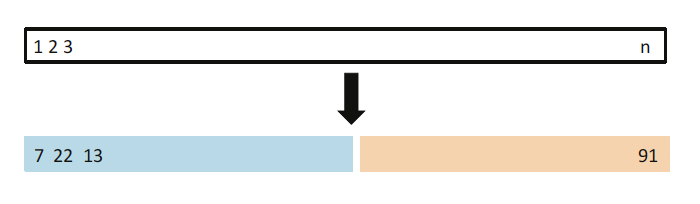

In [ ]:
## With 50% split (no urban_log)
y = educ['education_log']
X = educ[['income_log', 'young_log']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 1234)
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
np.sum((y_pred - y_test) ** 2)

In [ ]:
## With 50% split (with urban_log)
y = educ['education_log']
X = educ[['income_log', 'young_log', 'urban_log']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 1234)
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
np.sum((y_pred - y_test) ** 2)

In [ ]:
## Your turn: Check the MSE when removing income_log. Is it
##  better?

In [ ]:
## Your turn: Check the MSE when removing 'urban_pop' 
##   with only 20% of observations in the testing set.

## Cross-Validation

### Leave-One-Out Cross-Validation

- It does what it says: leaves one observation out and fits the model with $n-1$ cases.

- Then, it predicts the results in the case left out.

- **Great** for small datasets and when prediction is critical.

- **Bad** in terms of computational time.

$$ CV_n \ = \ \dfrac{1}{n}\sum_i MSE_i $$

## Cross-Validation

### Leave-One-Out Cross-Validation

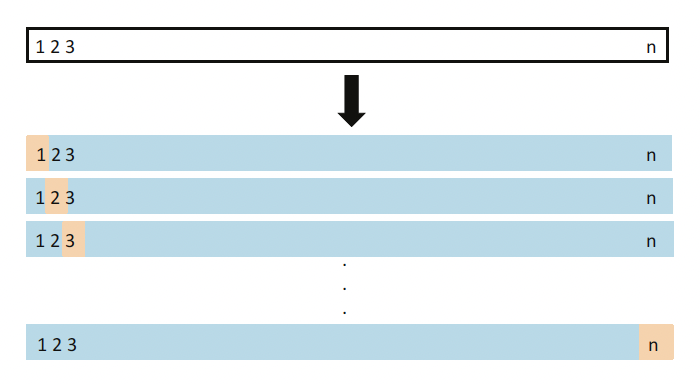

In [ ]:
## LOOCV
## Variables: model without urban population
y = educ['education_log']
X = educ[['income_log','young_log']]

## Leave-One-Out-CV
cv = LeaveOneOut()
reg = LinearRegression()

## Run the CV
scores = cross_val_score(reg, X, y,
                         scoring = 'neg_mean_squared_error',
                         cv = cv)

## RMSE
np.sqrt(np.mean(np.absolute(scores)))

In [ ]:
## LOOCV
## Variables: model **with** urban population
y = educ['education_log']
X = educ[['income_log', 'young_log', 'urban_log']]

## Leave-One-Out-CV
cv = LeaveOneOut()
reg = LinearRegression()


## Run the CV
scores = cross_val_score(reg, X, y, 
                         scoring = 'neg_mean_squared_error',
                         cv = cv)

## RMSE
np.sqrt(np.mean(np.absolute(scores)))

In [ ]:
## Your turn: compare the model with x without logs
## Note: the target has to be the same!

## Cross-Validation

### Metrics

- To do the comparison, you need a metric.

- `scikit learn` has many matrics available:

In [ ]:
## Lots of stats to compute the error:
print(get_scorer_names())

In [ ]:
## Your turn: find and use R-squared as the parameter for a
## LOOCV. What is the difference?

## Cross-Validation

### K-Fold Cross-Validation

- Leaves $k$ groups out and fits the model with the observations outside each group.

- Then, it predicts the results in the cases left out.

- **Great** in most cases.

- **Bad** *sometimes* computationally expensive.

$$ CV_k \ = \ \dfrac{1}{k}\sum_i MSE_i $$

## Cross-Validation

### K-Fold Cross-Validation

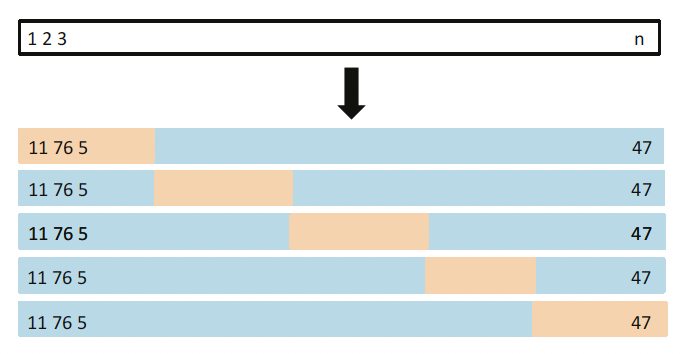

In [ ]:
## K-Fold CV (k = 5)
y = educ['education_log']
X = educ[['income_log', 'young_log']]

## k-Fold CV (n_splits = k, shuffle: reshuffle data before split)
cv = KFold(n_splits = 5, random_state = 1234, shuffle = True) 
reg = LinearRegression()


## Run the CV
scores = cross_val_score(reg, X, y,
                         scoring = 'neg_mean_squared_error',
                         cv = cv)

## RMSE
np.sqrt(np.mean(np.absolute(scores)))

In [ ]:
## K-Fold CV (k = 5)
y = educ['education_log']
X = educ[['income_log', 'young_log', 'urban_log']]

## k-Fold CV (n_splits = k, shuffle: reshuffle data before split)
cv = KFold(n_splits = 5, random_state = 1234, shuffle = True) 
reg = LinearRegression()


## Run the CV
scores = cross_val_score(reg, X, y,
                         scoring = 'neg_mean_squared_error',
                         cv = cv)

## RMSE
np.sqrt(np.mean(np.absolute(scores)))

In [ ]:
## Your turn: Run a 10-fold CV? Any differences?

## Cross-Validation

### Bias-Variance Trade-off

- k-Fold CV is more computationally efficient than LOOCV. But how about Bias-Variance Trade-offs?

- Larger fractions in a two-split leads to high bias: over-estimates the error rates.

- LOOCV: leaves just one, so it gives an unbiased estimate of the testing error rates: 
    + Very good for bias reduction!

## Cross-Validation

### Bias-Variance Trade-off

- LOOCV has high variance: almost the same observations at each run!
    + Very bad for variance.
    
- k-Fold CV:
    + Each subset is a *bit more different* than the other.
    + Leads to less correlation between each fold.
    + Good balance usually with $k=5$ or $k=10$.

## Cross-Validation

### Bias-Variance Trade-off

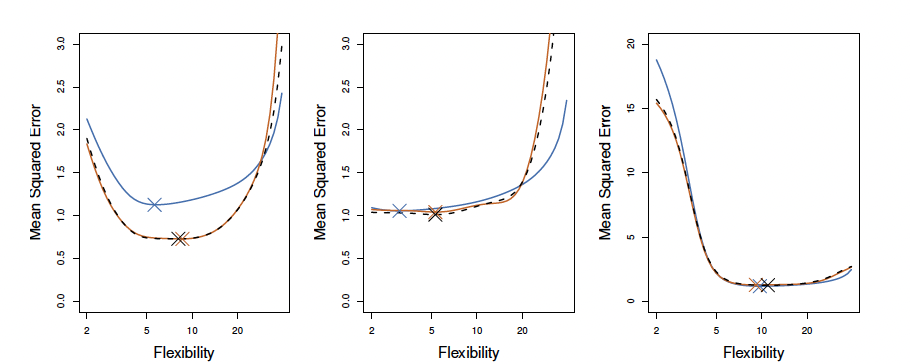

## Cross-Validation

### CV on Classification Problems

- When we have a classification, we must change how we evaluate the error.

- With classification, the LOOCV would look like this:

$$ CV_n \ = \ \dfrac{1}{n} \sum_i I(y_i \neq \widehat{y}_i) $$

- And the `accuracy` measure will be $I(y_i = \widehat{y}_i)$, so we need to subtract 1.

## Cross-Validation

### CV on Classification Problems

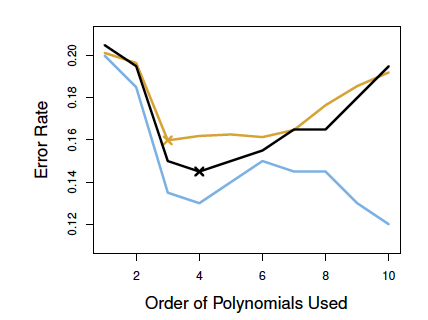

In [ ]:
## LOOCV on a Logistic Regression
# Checking best polynomial for Age
poly = list(range(1, 6))
errmea = []
y = chile_clean['vote']
for p in poly:
    if p == 1:
        X = pd.DataFrame({
            'age_1': chile_clean['age']
        })
    else:
        X['age_' + str(p)] = X['age_1'] ** p
    cv = LeaveOneOut()
    logreg = LogisticRegression()
    scores = cross_val_score(logreg, X, y, 
                             scoring = 'accuracy',
                             cv = cv, n_jobs = -1)
    print('For polynomial order {a}, the Logistic Regression Error Rate is {b}.\n'.format(a = str(p), b = str(1-scores.mean())))
    errmea.append(1-scores.mean())

## Classification

### K-Nearest Neighbors Classifier

- Little detour back to talk about a good algorithm for classification (also very intuitive).

- Given an integer $K$, and a test observation, it says that:

$$ \mathbb{P}(Y = j| X = x_0) \ = \ \dfrac{1}{K}\sum_{i \in N_0} I(y_i = j) $$

- Meaning: classify the observation based on the class of the closest $K$ obs:
    + The one more frequent is the winner.
    
- Closest: the idea of a metric.

## Classification

### K-Nearest Neighbors Classifier

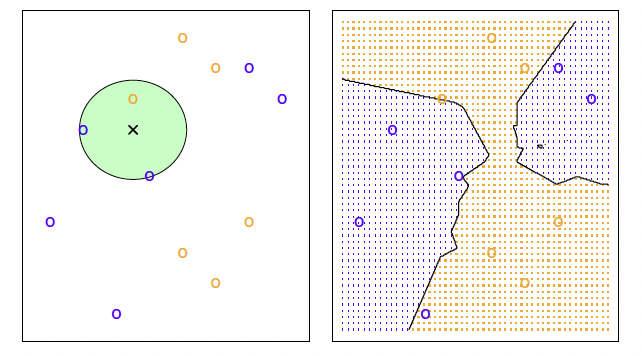

## Classification

### K-Nearest Neighbors Classifier

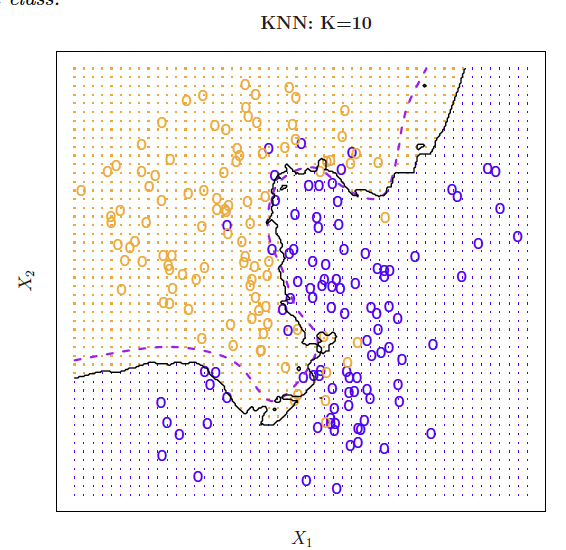

In [ ]:
# KNN
X = chile_clean[['age', 'statusquo']]
y = chile_clean['vote']

# Create the model
knn = KNeighborsClassifier(n_neighbors = 10).fit(X, y)

# Plotting the tree boundaries
fig = DecisionBoundaryDisplay.from_estimator(knn, X, response_method="predict",
                                             alpha=0.5, cmap=plt.cm.coolwarm)

# Plotting the data points    
fig.ax_.scatter(x = chile_clean['age'], y = chile_clean['statusquo'], 
                c = y, alpha = 0.5,
                cmap = plt.cm.coolwarm)

plt.show()

In [ ]:
## Now choose K!
bigK = list(range(1, 100))
errmea = []
y = chile_clean['vote']
X = chile_clean[['statusquo', 'logincome', 'logpop', 'age']]
for smallk in bigK:
    cv = KFold(n_splits = 10, random_state = 1234, shuffle = True)
    knn = KNeighborsClassifier(n_neighbors = smallk)
    scores = cross_val_score(knn, X, y, 
                             scoring = 'accuracy',
                             cv = cv, n_jobs = -1)
    errmea.append(1-scores.mean())
print('Best K is {a}.'.format(a = str(bigK[errmea.index(min(errmea))])))

In [ ]:
sns.lineplot(x = bigK, y = errmea)
plt.title('KNN algorithm')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.scatter(bigK[errmea.index(min(errmea))], min(errmea), marker='X', color = 'red')
plt.show()

# Questions?

# See you next class


In [ ]:
## Prestige Dataset
prestige = pd.read_csv('https://raw.githubusercontent.com/umbertomig/POLI175public/main/data/Duncan.csv')
prestige = prestige.set_index('profession')
dummies = pd.get_dummies(prestige['type'], prefix = 'type', drop_first = True)
prestige = pd.concat([prestige, dummies], axis=1)
prestige.head()